In [56]:
!pip install textblob

In [58]:
!pip install -U spacy

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Imadeddine\\anaconda3\\Lib\\site-packages\\~hinc\\backends\\linalg.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.4
    Uninstalling catalogue-2.0.4:
      Successfully uninstalled catalogue-2.0.4
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.6
    Uninstalling thinc-8.0.6:
      Successfully uninstalled thinc-8.0.6


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os, sys
import json
from sklearn.linear_model import LogisticRegression
import csv

## for plotting
import seaborn as sns

## for processing
import re
import nltk

## for sentiment
from textblob import TextBlob

## for vectorizer
from sklearn import feature_extraction, manifold

## for word embedding
import gensim.downloader as gensim_api

## for topic modeling
import gensim

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
root_path = os.getcwd()
data_path = os.path.join(root_path, "Data")

train_path = os.path.join(data_path, "train_set.json")
test_path = os.path.join(data_path, "test_set.json")
documents_path = os.path.join(data_path, "documents.json")

In [3]:
f = open(train_path)
train_set = json.load(f)
f = open(test_path)
test_set = json.load(f)
f = open(documents_path)
documents = json.load(f)

In [4]:
train_df = pd.read_json(train_path)
test_df = pd.read_json(test_path)
documents_df = pd.read_json(documents_path)

In [5]:
train_df.shape, documents_df.shape, test_df.shape

((8000, 3), (50000, 1), (3200, 2))

In [6]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return : cleaned text
    '''
    
    ## clean (convert to lowercase and remove punctuations and    characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
lst_stopwords = nltk.corpus.stopwords.words("english")

train_df["text_clean_summary"] = train_df["summary"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

train_df["text_clean_document"] = train_df["document"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [48]:
## Character length
train_df['character_cnt_summary'] = train_df['text_clean_summary'].str.len()
train_df['character_cnt_document'] = train_df['text_clean_document'].str.len()

train_df.groupby('label')['character_cnt_summary'].mean()

label
0    193.98325
1    198.50725
Name: character_cnt_summary, dtype: float64

In [49]:
train_df.groupby('label')['character_cnt_document'].mean()

label
0    2384.98025
1    2419.85900
Name: character_cnt_document, dtype: float64

In [50]:
train_df['word_counts_summary'] = train_df['text_clean_summary'].str.split().str.len()
train_df['word_counts_document'] = train_df['text_clean_document'].str.split().str.len()
train_df.groupby('label')['word_counts_summary'].mean()

label
0    30.85575
1    31.75800
Name: word_counts_summary, dtype: float64

In [51]:
train_df.groupby('label')['word_counts_document'].mean()

label
0    379.69925
1    385.23025
Name: word_counts_document, dtype: float64

In [52]:
train_df.head()

,document,summary,label,text_clean_summary,text_clean_document,word_counts_summary,word_counts_document,character_cnt_summary,character_cnt_document
0,Two GOP presidential hopefuls - Ted Cruz and B...,Ted Cruz and Ben Carson want the charity to re...,1,ted cruz ben carson want chariti return everi ...,two gop presidenti hope ted cruz ben carson wa...,85,702,538,4591
1,The Tesla Model S P85D's 'insane mode' may be ...,"latvia-based drive eo has created a vehicle, n...",0,latviabas drive eo creat vehicl name eo pp03 r...,tesla model p85d insan mode may fast new elect...,45,386,257,2239
2,MI5 has issued an alert over the threat posed ...,"Alert issued over rogue workers in nuclear , t...",1,alert issu rogu worker nuclear transport publi...,mi5 issu alert threat pose rogu worker britain...,34,276,205,1816
3,A new video that shows homeless people reading...,A short film highlights the nasty things peopl...,1,short film highlight nasti thing peopl say hom...,new video show homeless peopl read cruel tweet...,22,513,132,3039
4,Aston Villa may be gearing up for an FA Cup se...,tim sherwood replied to a letter from charlie ...,0,tim sherwood repli letter charli pye tuesday p...,aston villa may gear fa cup semifin clash live...,28,136,174,822


C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

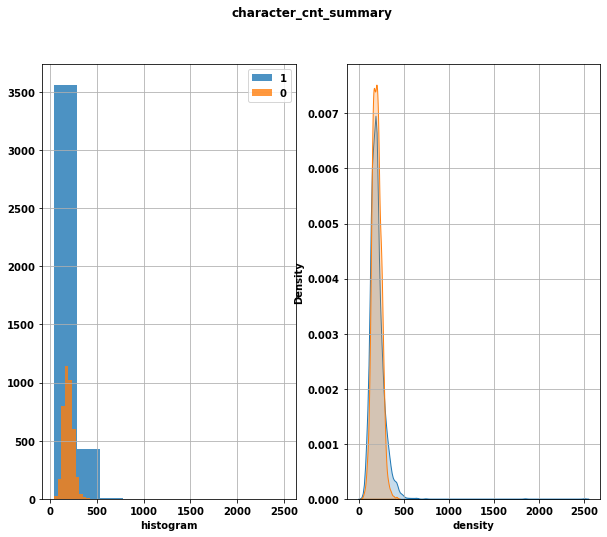

In [53]:
x, y = "character_cnt_summary", "label"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
fig.suptitle(x, fontsize=12)
for i in train_df[y].unique():
    sns.distplot(train_df[train_df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train_df[train_df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train_df[y].unique())
ax[1].grid(True)
plt.show()

C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

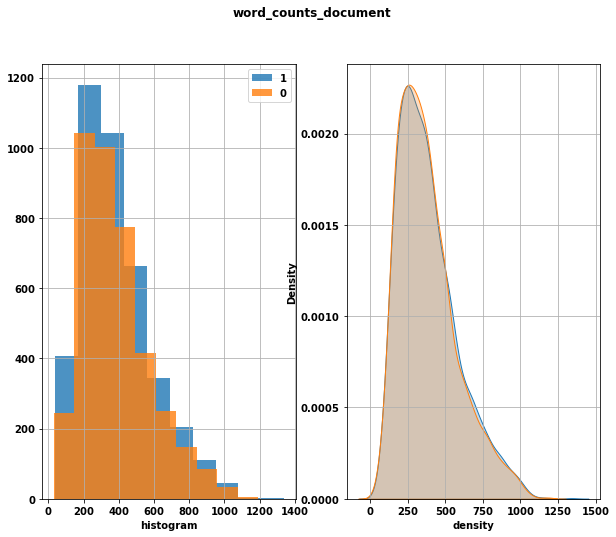

In [67]:
x, y = "word_counts_document", "label"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
fig.suptitle(x, fontsize=12)
for i in train_df[y].unique():
    sns.distplot(train_df[train_df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train_df[train_df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train_df[y].unique())
ax[1].grid(True)
plt.show()

In [63]:
## Sentiment Analysis

train_df["sentiment"] = train_df["summary"].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)

In [64]:
train_df.head(n=4)

,document,summary,label,text_clean_summary,text_clean_document,word_counts_summary,word_counts_document,character_cnt_summary,character_cnt_document,sentiment
0,Two GOP presidential hopefuls - Ted Cruz and B...,Ted Cruz and Ben Carson want the charity to re...,1,ted cruz ben carson want chariti return everi ...,two gop presidenti hope ted cruz ben carson wa...,85,702,538,4591,-0.004895
1,The Tesla Model S P85D's 'insane mode' may be ...,"latvia-based drive eo has created a vehicle, n...",0,latviabas drive eo creat vehicl name eo pp03 r...,tesla model p85d insan mode may fast new elect...,45,386,257,2239,0.100000
2,MI5 has issued an alert over the threat posed ...,"Alert issued over rogue workers in nuclear , t...",1,alert issu rogu worker nuclear transport publi...,mi5 issu alert threat pose rogu worker britain...,34,276,205,1816,-0.050000
3,A new video that shows homeless people reading...,A short film highlights the nasty things peopl...,1,short film highlight nasti thing peopl say hom...,new video show homeless peopl read cruel tweet...,22,513,132,3039,-0.500000


C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Imadeddine\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

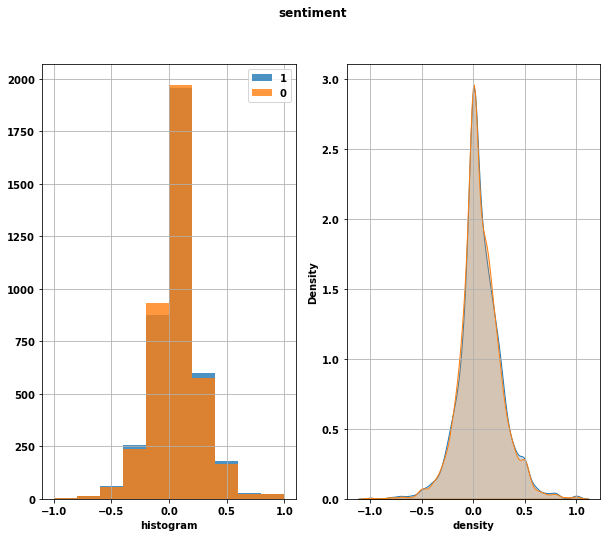

In [65]:
x, y = "sentiment", "label"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
fig.suptitle(x, fontsize=12)
for i in train_df[y].unique():
    sns.distplot(train_df[train_df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train_df[train_df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train_df[y].unique())
ax[1].grid(True)
plt.show()

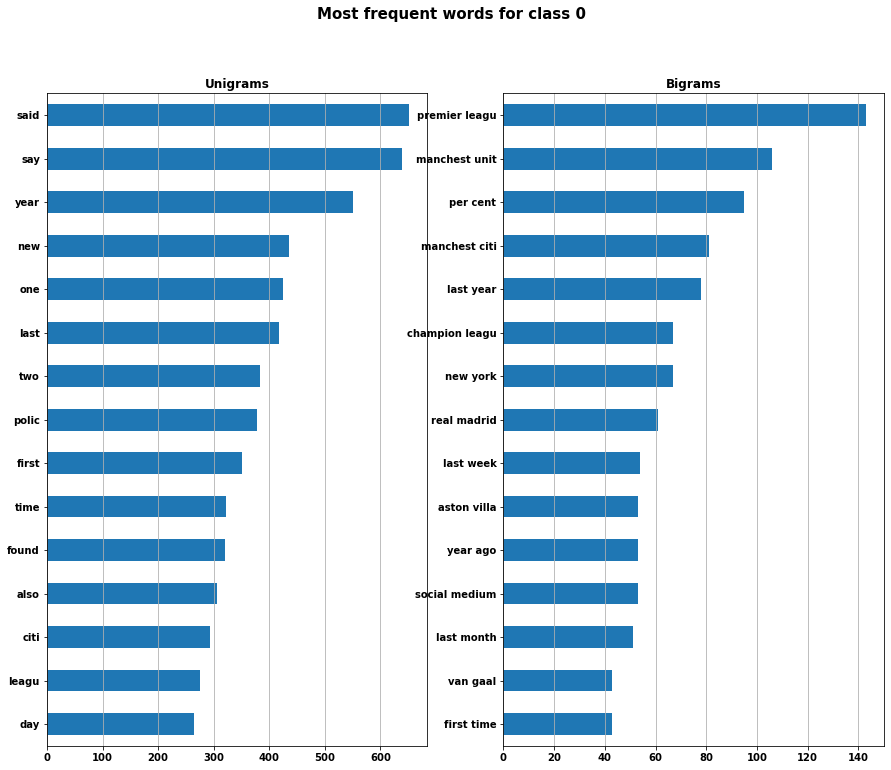

In [83]:
y = 0
corpus = train_df[train_df["label"]==y]["text_clean_summary"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
fig.suptitle("Most frequent words for class 0", fontsize=15)
top = 15

## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

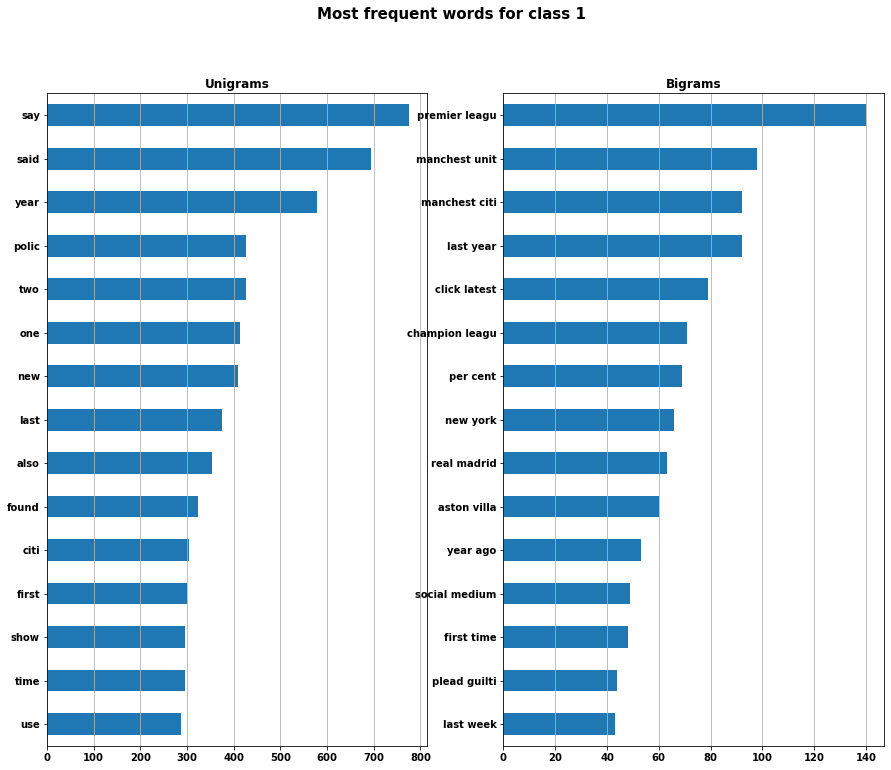

In [84]:
y = 1
corpus = train_df[train_df["label"]==y]["text_clean_summary"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
fig.suptitle("Most frequent words for class 1", fontsize=15)
top = 15

## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [110]:
!!pip install emoji

['Requirement already satisfied: emoji in c:\\users\\imadeddine\\anaconda3\\lib\\site-packages (0.6.0)']

In [8]:
import re
from string import punctuation
from emoji import UNICODE_EMOJI

def clean_texts(df):
    # remove URL
    df['text_proc'] = df['text'].str.replace(r'http(\S)+', r'')
    df['text_proc'].fillna('', inplace=True)
    df['text_proc'] = df['text_proc'].str.replace(r'http ...', r'')
    df['text_proc'] = df['text_proc'].str.replace(r'http', r'')

    # remove RT, @
    df['text_proc'] = df['text_proc'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+', r'')
    df['text_proc'] = df['text_proc'].str.replace(r'@[\S]+', r'')

    # remove non-ascii words and characters
    df['text_proc'] = [''.join([i if ord(i) < 128 else '' for i in text]) for text in df['text_proc'].values]
    df['text_proc'] = df['text_proc'].str.replace(r'_[\S]?', r'')

    # remove &, < and >
    df['text_proc'] = df['text_proc'].str.replace(r'&amp;?', r'and')
    df['text_proc'] = df['text_proc'].str.replace(r'&lt;', r'<')
    df['text_proc'] = df['text_proc'].str.replace(r'&gt;', r'>')

    # remove extra space
    df['text_proc'] = df['text_proc'].str.replace(r'[ ]{2, }', r' ')

    # insert space between punctuation marks
    df['text_proc'] = df['text_proc'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
    df['text_proc'] = df['text_proc'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')

    # lower case and strip white spaces at both ends
    df['text_proc'] = df['text_proc'].str.lower()
    df['text_proc'] = df['text_proc'].str.strip()
    return df

def add_text_features(df_, column = "summary"):
    df = df_.copy()
    df['text'] = df[column]
    df = clean_texts(df)
    df['text_length'] = df['text'].str.len()
    df['text_proc_length'] = df['text_proc'].str.len()
    df['text_proc_length_to_text_length'] = df['text_proc_length'] / df['text_length']
    df['text_lines_count'] = df['text'].str.count('\n')
    df['text_word_count'] = df['text'].str.split().apply(len)
    df['text_proc_word_count'] = df['text_proc'].str.split().apply(len)
    df['text_proc_word_count_to_text_word_count'] = df['text_proc_word_count'] / df['text_word_count']
    df['text_mean_word_length'] = df['text'].str.split().apply(lambda arr: np.mean([len(word) for word in arr]))
    df['text_proc_mean_word_length'] = df['text_proc'].str.split().apply(lambda arr: np.mean([len(word) for word in arr]))
    df['text_proc_mean_word_length_to_text_mean_word_length'] = df['text_proc_mean_word_length'] / df['text_mean_word_length']
    df['text_proc_alphas_count'] = df['text_proc'].apply(lambda s: sum(c.isalpha() for c in s))
    df['text_alphas_count'] = df['text'].apply(lambda s: sum(c.isalpha() for c in s))
    df['text_proc_alphas_count_to_text_alphas_count'] = df['text_proc_alphas_count'] / df['text_alphas_count']
    df['text_alphas_percent'] = df['text_alphas_count'] / df['text_length']
    df['text_non_alphas_count'] = df['text'].apply(lambda s: sum(not c.isalpha() for c in s))
    df['text_digits_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['text_digits_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['text_emoji_count'] = df['text'].apply(lambda s: sum(c in UNICODE_EMOJI for c in s))
    df['text_emoji_percent'] = df['text_emoji_count'] / df['text_length']
    df['text_has_emoji'] = (df['text_emoji_count'] > 0).astype(int)
    df['text_upper_letter_count'] = df['text'].apply(lambda s: sum(1 for c in s if c.isupper()))
    df['text_upper_letter_count_to_word_count'] = df['text_upper_letter_count'] / df['text_word_count']
    df['text_upper_letter_count_to_length'] = df['text_upper_letter_count'] / df['text_length']
    df['text_urls_count'] = df['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
    df['text_urls_count_to_words_count'] = df['text_urls_count'] / df['text_word_count']
    df['text_hashtags_count'] = df['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
    df['text_hashtags_count_to_words_count'] = df['text_hashtags_count'] / df['text_word_count']
    df['text_usertag_count'] = df['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))
    df['text_usertags_count_to_words_count'] = df['text_usertag_count'] / df['text_word_count']
    df['text_punctuation_count'] = df['text'].apply(lambda s: sum(1 for c in s if c in punctuation))
    df['text_proc_punctuation_count'] = df['text_proc'].apply(lambda s: sum(1 for c in s if c in punctuation))
    df['text_punctuation_rate'] = df['text_punctuation_count'] / df['text_length']
    df['text_punctuation_to_alpha'] = df['text_punctuation_count'] / df['text_alphas_count']
    df['text_proc_punctuation_to_alpha'] = df['text_proc_punctuation_count'] / df['text_proc_alphas_count']
    df['text_punctuation_unique_count'] = df['text'].apply(lambda s: len(set([c for c in s if c in punctuation])))
    df['text_proc_count_!'] = df['text_proc'].apply(lambda s: sum(c == '!' for c in s))
    df['text_proc_count_?'] = df['text_proc'].apply(lambda s: sum(c == '?' for c in s))

    return df

In [12]:
train_df = pd.read_json(train_path)
documents_df = pd.read_json(documents_path)

ext_train_df_summary = add_text_features(train_df, "summary")
ext_train_df_document = add_text_features(train_df, "document")

<AxesSubplot:>

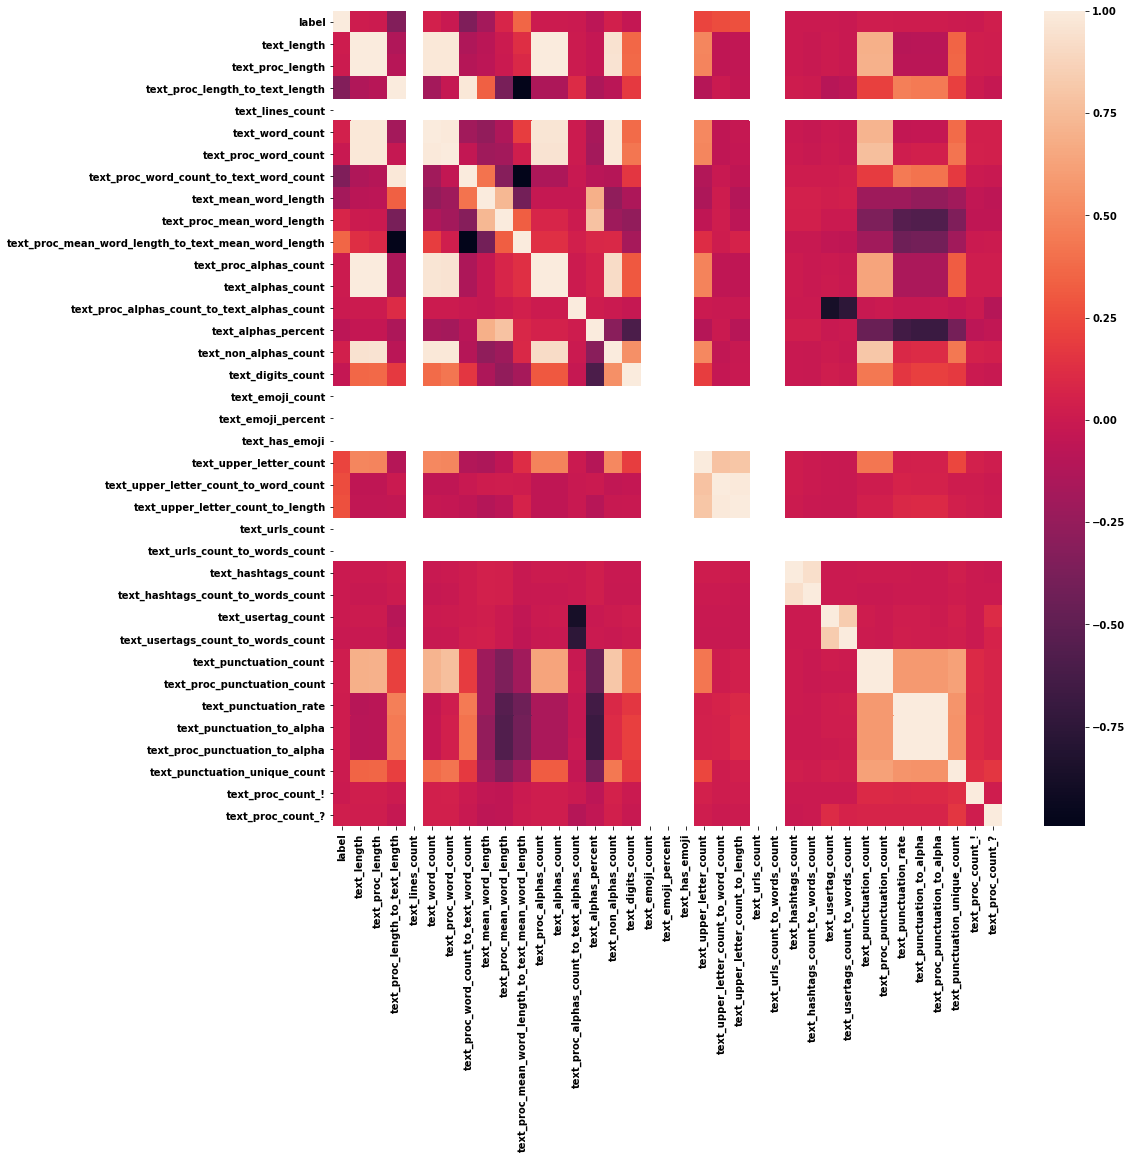

In [132]:
import seaborn as sns

corr = ext_train_df_summary.corr()

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, xticklabels = corr.columns,  yticklabels=corr.columns)

In [133]:
corr["label"].sort_values(ascending=False)

label                                                  1.000000
text_proc_mean_word_length_to_text_mean_word_length    0.358988
text_upper_letter_count_to_length                      0.273434
text_upper_letter_count_to_word_count                  0.253093
text_upper_letter_count                                0.227076
text_proc_mean_word_length                             0.080295
text_word_count                                        0.048605
text_non_alphas_count                                  0.037714
text_proc_count_?                                      0.027687
text_punctuation_count                                 0.024217
text_proc_punctuation_count                            0.024026
text_punctuation_to_alpha                              0.016662
text_proc_punctuation_to_alpha                         0.016548
text_length                                            0.015402
text_punctuation_rate                                  0.012142
text_alphas_count                       

In [134]:
ext_train_df_summary = ext_train_df_summary.fillna(0)

In [135]:
corr = ext_train_df_summary.corr()
corr["label"].sort_values(ascending=False)

label                                                  1.000000
text_proc_mean_word_length_to_text_mean_word_length    0.358988
text_upper_letter_count_to_length                      0.273434
text_upper_letter_count_to_word_count                  0.253093
text_upper_letter_count                                0.227076
text_proc_mean_word_length                             0.080295
text_word_count                                        0.048605
text_non_alphas_count                                  0.037714
text_proc_count_?                                      0.027687
text_punctuation_count                                 0.024217
text_proc_punctuation_count                            0.024026
text_punctuation_to_alpha                              0.016662
text_proc_punctuation_to_alpha                         0.016548
text_length                                            0.015402
text_punctuation_rate                                  0.012142
text_alphas_count                       

In [136]:
ext_train_df_summary.columns

Index(['document', 'summary', 'label', 'text', 'text_proc', 'text_length',
       'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_word_length',
       'text_proc_mean_word_length',
       'text_proc_mean_word_length_to_text_mean_word_length',
       'text_proc_alphas_count', 'text_alphas_count',
       'text_proc_alphas_count_to_text_alphas_count', 'text_alphas_percent',
       'text_non_alphas_count', 'text_digits_count', 'text_emoji_count',
       'text_emoji_percent', 'text_has_emoji', 'text_upper_letter_count',
       'text_upper_letter_count_to_word_count',
       'text_upper_letter_count_to_length', 'text_urls_count',
       'text_urls_count_to_words_count', 'text_hashtags_count',
       'text_hashtags_count_to_words_count', 'text_usertag_count',
       'text_usertags_count_to_words_count', 'text_punctuation_count',
       'text_proc_punctuatio

In [161]:
ext_train_df_summary = ext_train_df_summary.drop(['document', 'summary', 'text', 'text_proc'], axis=1)

train_labels = ext_train_df_summary["label"]
ext_train_df_summary = ext_train_df_summary.drop("label", axis = 1)

In [162]:
numeric_features = ext_train_df_summary.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

In [163]:
X_train, X_test, y_train, y_test = train_test_split(ext_train_df_summary.replace([np.inf, -np.inf], np.nan), train_labels.astype(int), test_size=0.2, random_state = 42)

In [165]:
# print(y_train)
clf.fit(X_train, y_train)
print("\t\t Model train score: %.3f" % clf.score(X_train, y_train))
print("\t\t Model test score: %.3f" % clf.score(X_test, y_test))

preds = clf["classifier"].predict(X_train)
score_test = accuracy_score(y_train, preds)
print("\t\t X_train accuracy score: ", score_test)

preds = clf["classifier"].predict(X_test)
score_test = accuracy_score(y_test, preds)
print("\t\t Test accuracy score: ", score_test)

		 Model train score: 0.724
		 Model test score: 0.706
		 X_train accuracy score:  0.500625
		 Test accuracy score:  0.4975


------------------------------------------------------------------------------------------------------

In [168]:
model = CatBoostRegressor(iterations=3000, learning_rate=0.001, verbose = 1, task_type="GPU", devices='0')
model.fit(X_train, y_train)

0:	learn: 0.4998033	total: 24.9ms	remaining: 1m 14s
1:	learn: 0.4998005	total: 38.2ms	remaining: 57.3s
2:	learn: 0.4997760	total: 58.2ms	remaining: 58.2s
3:	learn: 0.4997733	total: 71.3ms	remaining: 53.4s
4:	learn: 0.4997680	total: 92.9ms	remaining: 55.7s
5:	learn: 0.4997548	total: 113ms	remaining: 56.5s
6:	learn: 0.4997455	total: 135ms	remaining: 57.6s
7:	learn: 0.4997443	total: 155ms	remaining: 58.1s
8:	learn: 0.4997027	total: 181ms	remaining: 1m
9:	learn: 0.4997017	total: 203ms	remaining: 1m
10:	learn: 0.4996686	total: 220ms	remaining: 59.8s
11:	learn: 0.4996630	total: 236ms	remaining: 58.9s
12:	learn: 0.4996623	total: 254ms	remaining: 58.3s
13:	learn: 0.4996581	total: 274ms	remaining: 58.5s
14:	learn: 0.4996555	total: 290ms	remaining: 57.8s
15:	learn: 0.4996554	total: 303ms	remaining: 56.5s
16:	learn: 0.4996542	total: 324ms	remaining: 56.9s
17:	learn: 0.4995380	total: 348ms	remaining: 57.6s
18:	learn: 0.4995350	total: 363ms	remaining: 57s
19:	learn: 0.4994892	total: 386ms	remaining

166:	learn: 0.4966685	total: 3.2s	remaining: 54.3s
167:	learn: 0.4966684	total: 3.21s	remaining: 54.2s
168:	learn: 0.4966617	total: 3.23s	remaining: 54.1s
169:	learn: 0.4966615	total: 3.24s	remaining: 53.9s
170:	learn: 0.4966593	total: 3.25s	remaining: 53.8s
171:	learn: 0.4966559	total: 3.26s	remaining: 53.6s
172:	learn: 0.4966266	total: 3.27s	remaining: 53.5s
173:	learn: 0.4965982	total: 3.29s	remaining: 53.4s
174:	learn: 0.4965424	total: 3.3s	remaining: 53.3s
175:	learn: 0.4965347	total: 3.32s	remaining: 53.3s
176:	learn: 0.4964962	total: 3.34s	remaining: 53.3s
177:	learn: 0.4964833	total: 3.37s	remaining: 53.4s
178:	learn: 0.4964707	total: 3.39s	remaining: 53.4s
179:	learn: 0.4964674	total: 3.4s	remaining: 53.2s
180:	learn: 0.4964643	total: 3.42s	remaining: 53.3s
181:	learn: 0.4964615	total: 3.44s	remaining: 53.3s
182:	learn: 0.4964557	total: 3.46s	remaining: 53.3s
183:	learn: 0.4964466	total: 3.48s	remaining: 53.2s
184:	learn: 0.4964464	total: 3.49s	remaining: 53.1s
185:	learn: 0.4

329:	learn: 0.4934204	total: 5.95s	remaining: 48.1s
330:	learn: 0.4934202	total: 5.96s	remaining: 48.1s
331:	learn: 0.4934187	total: 5.98s	remaining: 48.1s
332:	learn: 0.4933751	total: 5.99s	remaining: 48s
333:	learn: 0.4933716	total: 6.01s	remaining: 47.9s
334:	learn: 0.4933684	total: 6.03s	remaining: 47.9s
335:	learn: 0.4933681	total: 6.04s	remaining: 47.9s
336:	learn: 0.4933059	total: 6.06s	remaining: 47.9s
337:	learn: 0.4933051	total: 6.07s	remaining: 47.8s
338:	learn: 0.4932831	total: 6.09s	remaining: 47.8s
339:	learn: 0.4932745	total: 6.11s	remaining: 47.8s
340:	learn: 0.4932699	total: 6.14s	remaining: 47.9s
341:	learn: 0.4932558	total: 6.16s	remaining: 47.9s
342:	learn: 0.4932530	total: 6.18s	remaining: 47.9s
343:	learn: 0.4932155	total: 6.21s	remaining: 47.9s
344:	learn: 0.4932028	total: 6.23s	remaining: 47.9s
345:	learn: 0.4932002	total: 6.24s	remaining: 47.9s
346:	learn: 0.4931575	total: 6.25s	remaining: 47.8s
347:	learn: 0.4931555	total: 6.26s	remaining: 47.7s
348:	learn: 0.

488:	learn: 0.4905591	total: 8.74s	remaining: 44.9s
489:	learn: 0.4905572	total: 8.75s	remaining: 44.8s
490:	learn: 0.4905007	total: 8.77s	remaining: 44.8s
491:	learn: 0.4905003	total: 8.78s	remaining: 44.8s
492:	learn: 0.4904985	total: 8.8s	remaining: 44.7s
493:	learn: 0.4904961	total: 8.81s	remaining: 44.7s
494:	learn: 0.4904943	total: 8.83s	remaining: 44.7s
495:	learn: 0.4904497	total: 8.85s	remaining: 44.7s
496:	learn: 0.4904457	total: 8.87s	remaining: 44.7s
497:	learn: 0.4904339	total: 8.89s	remaining: 44.7s
498:	learn: 0.4903981	total: 8.91s	remaining: 44.7s
499:	learn: 0.4903958	total: 8.93s	remaining: 44.7s
500:	learn: 0.4903451	total: 8.96s	remaining: 44.7s
501:	learn: 0.4903192	total: 8.98s	remaining: 44.7s
502:	learn: 0.4902936	total: 8.99s	remaining: 44.6s
503:	learn: 0.4902521	total: 9.01s	remaining: 44.6s
504:	learn: 0.4902441	total: 9.04s	remaining: 44.6s
505:	learn: 0.4902365	total: 9.06s	remaining: 44.6s
506:	learn: 0.4902355	total: 9.06s	remaining: 44.6s
507:	learn: 0

658:	learn: 0.4876987	total: 11.5s	remaining: 40.9s
659:	learn: 0.4876919	total: 11.5s	remaining: 40.9s
660:	learn: 0.4875897	total: 11.6s	remaining: 40.9s
661:	learn: 0.4875862	total: 11.6s	remaining: 40.9s
662:	learn: 0.4875851	total: 11.6s	remaining: 40.8s
663:	learn: 0.4875831	total: 11.6s	remaining: 40.8s
664:	learn: 0.4875827	total: 11.6s	remaining: 40.8s
665:	learn: 0.4875781	total: 11.6s	remaining: 40.8s
666:	learn: 0.4875742	total: 11.6s	remaining: 40.7s
667:	learn: 0.4875681	total: 11.7s	remaining: 40.7s
668:	learn: 0.4875622	total: 11.7s	remaining: 40.7s
669:	learn: 0.4875543	total: 11.7s	remaining: 40.6s
670:	learn: 0.4875476	total: 11.7s	remaining: 40.6s
671:	learn: 0.4875222	total: 11.7s	remaining: 40.6s
672:	learn: 0.4875048	total: 11.8s	remaining: 40.6s
673:	learn: 0.4874960	total: 11.8s	remaining: 40.6s
674:	learn: 0.4874784	total: 11.8s	remaining: 40.6s
675:	learn: 0.4874390	total: 11.8s	remaining: 40.6s
676:	learn: 0.4874354	total: 11.8s	remaining: 40.6s
677:	learn: 

820:	learn: 0.4848187	total: 14.1s	remaining: 37.5s
821:	learn: 0.4847992	total: 14.1s	remaining: 37.4s
822:	learn: 0.4847958	total: 14.1s	remaining: 37.4s
823:	learn: 0.4847896	total: 14.2s	remaining: 37.4s
824:	learn: 0.4847708	total: 14.2s	remaining: 37.3s
825:	learn: 0.4847685	total: 14.2s	remaining: 37.3s
826:	learn: 0.4847671	total: 14.2s	remaining: 37.3s
827:	learn: 0.4847483	total: 14.2s	remaining: 37.2s
828:	learn: 0.4847469	total: 14.2s	remaining: 37.2s
829:	learn: 0.4847365	total: 14.2s	remaining: 37.2s
830:	learn: 0.4847296	total: 14.3s	remaining: 37.2s
831:	learn: 0.4846881	total: 14.3s	remaining: 37.2s
832:	learn: 0.4846787	total: 14.3s	remaining: 37.2s
833:	learn: 0.4846726	total: 14.3s	remaining: 37.1s
834:	learn: 0.4846710	total: 14.3s	remaining: 37.1s
835:	learn: 0.4846686	total: 14.3s	remaining: 37.1s
836:	learn: 0.4846015	total: 14.4s	remaining: 37.1s
837:	learn: 0.4845983	total: 14.4s	remaining: 37.1s
838:	learn: 0.4845953	total: 14.4s	remaining: 37.1s
839:	learn: 

985:	learn: 0.4823839	total: 16.7s	remaining: 34.1s
986:	learn: 0.4823817	total: 16.7s	remaining: 34.1s
987:	learn: 0.4823613	total: 16.7s	remaining: 34.1s
988:	learn: 0.4823578	total: 16.7s	remaining: 34.1s
989:	learn: 0.4823527	total: 16.8s	remaining: 34s
990:	learn: 0.4823486	total: 16.8s	remaining: 34s
991:	learn: 0.4823467	total: 16.8s	remaining: 34s
992:	learn: 0.4823461	total: 16.8s	remaining: 34s
993:	learn: 0.4823254	total: 16.8s	remaining: 34s
994:	learn: 0.4823168	total: 16.9s	remaining: 34s
995:	learn: 0.4823114	total: 16.9s	remaining: 34s
996:	learn: 0.4822894	total: 16.9s	remaining: 33.9s
997:	learn: 0.4822888	total: 16.9s	remaining: 33.9s
998:	learn: 0.4822829	total: 16.9s	remaining: 33.9s
999:	learn: 0.4822791	total: 17s	remaining: 33.9s
1000:	learn: 0.4822782	total: 17s	remaining: 33.9s
1001:	learn: 0.4822748	total: 17s	remaining: 33.9s
1002:	learn: 0.4822733	total: 17s	remaining: 33.8s
1003:	learn: 0.4822549	total: 17s	remaining: 33.8s
1004:	learn: 0.4822540	total: 17

1144:	learn: 0.4804387	total: 19.3s	remaining: 31.3s
1145:	learn: 0.4804312	total: 19.3s	remaining: 31.3s
1146:	learn: 0.4804279	total: 19.3s	remaining: 31.2s
1147:	learn: 0.4804225	total: 19.4s	remaining: 31.2s
1148:	learn: 0.4804216	total: 19.4s	remaining: 31.2s
1149:	learn: 0.4802826	total: 19.4s	remaining: 31.2s
1150:	learn: 0.4802737	total: 19.4s	remaining: 31.2s
1151:	learn: 0.4802730	total: 19.4s	remaining: 31.2s
1152:	learn: 0.4802730	total: 19.4s	remaining: 31.1s
1153:	learn: 0.4802703	total: 19.4s	remaining: 31.1s
1154:	learn: 0.4802308	total: 19.5s	remaining: 31.1s
1155:	learn: 0.4801784	total: 19.5s	remaining: 31.1s
1156:	learn: 0.4801783	total: 19.5s	remaining: 31.1s
1157:	learn: 0.4801663	total: 19.5s	remaining: 31s
1158:	learn: 0.4801626	total: 19.5s	remaining: 31s
1159:	learn: 0.4801537	total: 19.6s	remaining: 31s
1160:	learn: 0.4801500	total: 19.6s	remaining: 31s
1161:	learn: 0.4801446	total: 19.6s	remaining: 31s
1162:	learn: 0.4801382	total: 19.6s	remaining: 31s
1163:

1301:	learn: 0.4786398	total: 21.7s	remaining: 28.3s
1302:	learn: 0.4786075	total: 21.7s	remaining: 28.3s
1303:	learn: 0.4786075	total: 21.7s	remaining: 28.2s
1304:	learn: 0.4786042	total: 21.7s	remaining: 28.2s
1305:	learn: 0.4785991	total: 21.8s	remaining: 28.2s
1306:	learn: 0.4785991	total: 21.8s	remaining: 28.2s
1307:	learn: 0.4785979	total: 21.8s	remaining: 28.2s
1308:	learn: 0.4785974	total: 21.8s	remaining: 28.2s
1309:	learn: 0.4785951	total: 21.8s	remaining: 28.1s
1310:	learn: 0.4785950	total: 21.8s	remaining: 28.1s
1311:	learn: 0.4785934	total: 21.8s	remaining: 28.1s
1312:	learn: 0.4784997	total: 21.9s	remaining: 28.1s
1313:	learn: 0.4784852	total: 21.9s	remaining: 28.1s
1314:	learn: 0.4784484	total: 21.9s	remaining: 28s
1315:	learn: 0.4784451	total: 21.9s	remaining: 28s
1316:	learn: 0.4784275	total: 21.9s	remaining: 28s
1317:	learn: 0.4784274	total: 21.9s	remaining: 28s
1318:	learn: 0.4784231	total: 21.9s	remaining: 28s
1319:	learn: 0.4784110	total: 22s	remaining: 27.9s
1320:

1457:	learn: 0.4764915	total: 24.1s	remaining: 25.5s
1458:	learn: 0.4764893	total: 24.1s	remaining: 25.5s
1459:	learn: 0.4764871	total: 24.1s	remaining: 25.4s
1460:	learn: 0.4764869	total: 24.1s	remaining: 25.4s
1461:	learn: 0.4764837	total: 24.2s	remaining: 25.4s
1462:	learn: 0.4764817	total: 24.2s	remaining: 25.4s
1463:	learn: 0.4763337	total: 24.2s	remaining: 25.4s
1464:	learn: 0.4763331	total: 24.2s	remaining: 25.4s
1465:	learn: 0.4763009	total: 24.2s	remaining: 25.4s
1466:	learn: 0.4762956	total: 24.3s	remaining: 25.3s
1467:	learn: 0.4762578	total: 24.3s	remaining: 25.3s
1468:	learn: 0.4762551	total: 24.3s	remaining: 25.3s
1469:	learn: 0.4762389	total: 24.3s	remaining: 25.3s
1470:	learn: 0.4762360	total: 24.3s	remaining: 25.3s
1471:	learn: 0.4762037	total: 24.3s	remaining: 25.3s
1472:	learn: 0.4761977	total: 24.4s	remaining: 25.3s
1473:	learn: 0.4761969	total: 24.4s	remaining: 25.2s
1474:	learn: 0.4761631	total: 24.4s	remaining: 25.2s
1475:	learn: 0.4761399	total: 24.4s	remaining:

1622:	learn: 0.4746286	total: 26.9s	remaining: 22.8s
1623:	learn: 0.4746187	total: 26.9s	remaining: 22.8s
1624:	learn: 0.4746144	total: 26.9s	remaining: 22.8s
1625:	learn: 0.4745946	total: 26.9s	remaining: 22.7s
1626:	learn: 0.4745904	total: 26.9s	remaining: 22.7s
1627:	learn: 0.4745892	total: 26.9s	remaining: 22.7s
1628:	learn: 0.4745857	total: 27s	remaining: 22.7s
1629:	learn: 0.4745624	total: 27s	remaining: 22.7s
1630:	learn: 0.4745288	total: 27s	remaining: 22.7s
1631:	learn: 0.4745246	total: 27s	remaining: 22.6s
1632:	learn: 0.4744517	total: 27s	remaining: 22.6s
1633:	learn: 0.4744507	total: 27.1s	remaining: 22.6s
1634:	learn: 0.4744451	total: 27.1s	remaining: 22.6s
1635:	learn: 0.4743291	total: 27.1s	remaining: 22.6s
1636:	learn: 0.4743210	total: 27.1s	remaining: 22.6s
1637:	learn: 0.4742965	total: 27.1s	remaining: 22.6s
1638:	learn: 0.4742955	total: 27.1s	remaining: 22.5s
1639:	learn: 0.4742954	total: 27.2s	remaining: 22.5s
1640:	learn: 0.4742953	total: 27.2s	remaining: 22.5s
164

1783:	learn: 0.4723173	total: 29.5s	remaining: 20.1s
1784:	learn: 0.4723129	total: 29.5s	remaining: 20.1s
1785:	learn: 0.4723050	total: 29.5s	remaining: 20.1s
1786:	learn: 0.4723030	total: 29.5s	remaining: 20s
1787:	learn: 0.4722852	total: 29.5s	remaining: 20s
1788:	learn: 0.4722834	total: 29.6s	remaining: 20s
1789:	learn: 0.4722579	total: 29.6s	remaining: 20s
1790:	learn: 0.4722575	total: 29.6s	remaining: 20s
1791:	learn: 0.4722270	total: 29.6s	remaining: 20s
1792:	learn: 0.4721040	total: 29.6s	remaining: 19.9s
1793:	learn: 0.4720965	total: 29.7s	remaining: 19.9s
1794:	learn: 0.4720841	total: 29.7s	remaining: 19.9s
1795:	learn: 0.4720825	total: 29.7s	remaining: 19.9s
1796:	learn: 0.4720799	total: 29.7s	remaining: 19.9s
1797:	learn: 0.4720782	total: 29.7s	remaining: 19.9s
1798:	learn: 0.4720776	total: 29.7s	remaining: 19.9s
1799:	learn: 0.4720749	total: 29.8s	remaining: 19.8s
1800:	learn: 0.4720744	total: 29.8s	remaining: 19.8s
1801:	learn: 0.4720566	total: 29.8s	remaining: 19.8s
1802:

1941:	learn: 0.4704707	total: 32s	remaining: 17.4s
1942:	learn: 0.4704696	total: 32s	remaining: 17.4s
1943:	learn: 0.4704687	total: 32.1s	remaining: 17.4s
1944:	learn: 0.4704649	total: 32.1s	remaining: 17.4s
1945:	learn: 0.4704620	total: 32.1s	remaining: 17.4s
1946:	learn: 0.4704575	total: 32.1s	remaining: 17.4s
1947:	learn: 0.4704132	total: 32.1s	remaining: 17.4s
1948:	learn: 0.4704046	total: 32.2s	remaining: 17.3s
1949:	learn: 0.4703758	total: 32.2s	remaining: 17.3s
1950:	learn: 0.4703751	total: 32.2s	remaining: 17.3s
1951:	learn: 0.4703750	total: 32.2s	remaining: 17.3s
1952:	learn: 0.4703739	total: 32.2s	remaining: 17.3s
1953:	learn: 0.4703715	total: 32.3s	remaining: 17.3s
1954:	learn: 0.4703690	total: 32.3s	remaining: 17.2s
1955:	learn: 0.4703616	total: 32.3s	remaining: 17.2s
1956:	learn: 0.4703604	total: 32.3s	remaining: 17.2s
1957:	learn: 0.4703597	total: 32.3s	remaining: 17.2s
1958:	learn: 0.4703596	total: 32.3s	remaining: 17.2s
1959:	learn: 0.4703594	total: 32.3s	remaining: 17.

2102:	learn: 0.4686852	total: 34.6s	remaining: 14.7s
2103:	learn: 0.4686563	total: 34.6s	remaining: 14.7s
2104:	learn: 0.4686496	total: 34.6s	remaining: 14.7s
2105:	learn: 0.4686495	total: 34.6s	remaining: 14.7s
2106:	learn: 0.4686481	total: 34.6s	remaining: 14.7s
2107:	learn: 0.4686442	total: 34.7s	remaining: 14.7s
2108:	learn: 0.4686393	total: 34.7s	remaining: 14.6s
2109:	learn: 0.4686379	total: 34.7s	remaining: 14.6s
2110:	learn: 0.4686346	total: 34.7s	remaining: 14.6s
2111:	learn: 0.4686339	total: 34.7s	remaining: 14.6s
2112:	learn: 0.4686336	total: 34.7s	remaining: 14.6s
2113:	learn: 0.4686335	total: 34.7s	remaining: 14.6s
2114:	learn: 0.4686273	total: 34.7s	remaining: 14.5s
2115:	learn: 0.4686258	total: 34.8s	remaining: 14.5s
2116:	learn: 0.4686088	total: 34.8s	remaining: 14.5s
2117:	learn: 0.4686076	total: 34.8s	remaining: 14.5s
2118:	learn: 0.4686068	total: 34.8s	remaining: 14.5s
2119:	learn: 0.4686064	total: 34.8s	remaining: 14.5s
2120:	learn: 0.4685818	total: 34.8s	remaining:

2268:	learn: 0.4666741	total: 37.2s	remaining: 12s
2269:	learn: 0.4666353	total: 37.2s	remaining: 12s
2270:	learn: 0.4666279	total: 37.2s	remaining: 11.9s
2271:	learn: 0.4666259	total: 37.2s	remaining: 11.9s
2272:	learn: 0.4666136	total: 37.2s	remaining: 11.9s
2273:	learn: 0.4666134	total: 37.2s	remaining: 11.9s
2274:	learn: 0.4666120	total: 37.3s	remaining: 11.9s
2275:	learn: 0.4666119	total: 37.3s	remaining: 11.9s
2276:	learn: 0.4666102	total: 37.3s	remaining: 11.8s
2277:	learn: 0.4665955	total: 37.3s	remaining: 11.8s
2278:	learn: 0.4665907	total: 37.3s	remaining: 11.8s
2279:	learn: 0.4665902	total: 37.3s	remaining: 11.8s
2280:	learn: 0.4665897	total: 37.3s	remaining: 11.8s
2281:	learn: 0.4665646	total: 37.4s	remaining: 11.8s
2282:	learn: 0.4665223	total: 37.4s	remaining: 11.7s
2283:	learn: 0.4665221	total: 37.4s	remaining: 11.7s
2284:	learn: 0.4665106	total: 37.4s	remaining: 11.7s
2285:	learn: 0.4665098	total: 37.4s	remaining: 11.7s
2286:	learn: 0.4665091	total: 37.4s	remaining: 11.

2424:	learn: 0.4645372	total: 39.5s	remaining: 9.38s
2425:	learn: 0.4645318	total: 39.6s	remaining: 9.36s
2426:	learn: 0.4645315	total: 39.6s	remaining: 9.34s
2427:	learn: 0.4644015	total: 39.6s	remaining: 9.33s
2428:	learn: 0.4643972	total: 39.6s	remaining: 9.31s
2429:	learn: 0.4642645	total: 39.6s	remaining: 9.3s
2430:	learn: 0.4642636	total: 39.7s	remaining: 9.28s
2431:	learn: 0.4642589	total: 39.7s	remaining: 9.26s
2432:	learn: 0.4642569	total: 39.7s	remaining: 9.25s
2433:	learn: 0.4642551	total: 39.7s	remaining: 9.23s
2434:	learn: 0.4642492	total: 39.7s	remaining: 9.22s
2435:	learn: 0.4642436	total: 39.7s	remaining: 9.2s
2436:	learn: 0.4642185	total: 39.8s	remaining: 9.19s
2437:	learn: 0.4642179	total: 39.8s	remaining: 9.17s
2438:	learn: 0.4642155	total: 39.8s	remaining: 9.15s
2439:	learn: 0.4642007	total: 39.8s	remaining: 9.14s
2440:	learn: 0.4641998	total: 39.8s	remaining: 9.12s
2441:	learn: 0.4641990	total: 39.8s	remaining: 9.1s
2442:	learn: 0.4641982	total: 39.8s	remaining: 9.

2589:	learn: 0.4624596	total: 42.1s	remaining: 6.67s
2590:	learn: 0.4624592	total: 42.1s	remaining: 6.65s
2591:	learn: 0.4624591	total: 42.1s	remaining: 6.63s
2592:	learn: 0.4624350	total: 42.2s	remaining: 6.62s
2593:	learn: 0.4624342	total: 42.2s	remaining: 6.6s
2594:	learn: 0.4624060	total: 42.2s	remaining: 6.59s
2595:	learn: 0.4624024	total: 42.2s	remaining: 6.57s
2596:	learn: 0.4623994	total: 42.2s	remaining: 6.55s
2597:	learn: 0.4623984	total: 42.3s	remaining: 6.54s
2598:	learn: 0.4622857	total: 42.3s	remaining: 6.52s
2599:	learn: 0.4622815	total: 42.3s	remaining: 6.51s
2600:	learn: 0.4622550	total: 42.3s	remaining: 6.49s
2601:	learn: 0.4622543	total: 42.3s	remaining: 6.47s
2602:	learn: 0.4622486	total: 42.3s	remaining: 6.46s
2603:	learn: 0.4622007	total: 42.3s	remaining: 6.44s
2604:	learn: 0.4621997	total: 42.4s	remaining: 6.42s
2605:	learn: 0.4621990	total: 42.4s	remaining: 6.41s
2606:	learn: 0.4621940	total: 42.4s	remaining: 6.39s
2607:	learn: 0.4621926	total: 42.4s	remaining: 

2756:	learn: 0.4603006	total: 44.7s	remaining: 3.94s
2757:	learn: 0.4603003	total: 44.7s	remaining: 3.92s
2758:	learn: 0.4602740	total: 44.7s	remaining: 3.91s
2759:	learn: 0.4602740	total: 44.7s	remaining: 3.89s
2760:	learn: 0.4602512	total: 44.8s	remaining: 3.87s
2761:	learn: 0.4602409	total: 44.8s	remaining: 3.86s
2762:	learn: 0.4602398	total: 44.8s	remaining: 3.84s
2763:	learn: 0.4602055	total: 44.8s	remaining: 3.83s
2764:	learn: 0.4602053	total: 44.8s	remaining: 3.81s
2765:	learn: 0.4601954	total: 44.8s	remaining: 3.79s
2766:	learn: 0.4601949	total: 44.8s	remaining: 3.78s
2767:	learn: 0.4601680	total: 44.9s	remaining: 3.76s
2768:	learn: 0.4601668	total: 44.9s	remaining: 3.74s
2769:	learn: 0.4601669	total: 44.9s	remaining: 3.73s
2770:	learn: 0.4601570	total: 44.9s	remaining: 3.71s
2771:	learn: 0.4601417	total: 44.9s	remaining: 3.69s
2772:	learn: 0.4601115	total: 44.9s	remaining: 3.68s
2773:	learn: 0.4600772	total: 45s	remaining: 3.66s
2774:	learn: 0.4600711	total: 45s	remaining: 3.6

2914:	learn: 0.4585851	total: 47.1s	remaining: 1.37s
2915:	learn: 0.4585773	total: 47.1s	remaining: 1.36s
2916:	learn: 0.4585771	total: 47.1s	remaining: 1.34s
2917:	learn: 0.4585748	total: 47.1s	remaining: 1.32s
2918:	learn: 0.4585714	total: 47.1s	remaining: 1.31s
2919:	learn: 0.4585692	total: 47.2s	remaining: 1.29s
2920:	learn: 0.4585673	total: 47.2s	remaining: 1.27s
2921:	learn: 0.4584539	total: 47.2s	remaining: 1.26s
2922:	learn: 0.4584278	total: 47.2s	remaining: 1.24s
2923:	learn: 0.4584005	total: 47.2s	remaining: 1.23s
2924:	learn: 0.4583838	total: 47.2s	remaining: 1.21s
2925:	learn: 0.4583817	total: 47.3s	remaining: 1.2s
2926:	learn: 0.4583808	total: 47.3s	remaining: 1.18s
2927:	learn: 0.4583771	total: 47.3s	remaining: 1.16s
2928:	learn: 0.4583769	total: 47.3s	remaining: 1.15s
2929:	learn: 0.4583753	total: 47.3s	remaining: 1.13s
2930:	learn: 0.4583742	total: 47.3s	remaining: 1.11s
2931:	learn: 0.4583742	total: 47.3s	remaining: 1.1s
2932:	learn: 0.4583733	total: 47.4s	remaining: 1

In [174]:
preds = model.predict(X_train)
preds = [0 if item <= 0.5 else 1 for item in preds]
score_test = accuracy_score(y_train, preds)
print("\t\t X_train accuracy score: ", score_test)

preds = model.predict(X_test)
preds = [0 if item <= 0.5 else 1 for item in preds]
score_test = accuracy_score(y_test, preds)
print("\t\t Test accuracy score: ", score_test)

		 X_train accuracy score:  0.7625
		 Test accuracy score:  0.754375


In [176]:
ext_test_df_summary = add_text_features(test_df, "summary")

ext_test_df_summary = ext_test_df_summary.drop(['document', 'summary', 'text', 'text_proc'], axis=1)

In [178]:
predictions = model.predict(ext_test_df_summary)
predictions = [0 if item <= 0.5 else 1 for item in predictions]

In [179]:
# Write predictions to a file
with open("submission_FeatGen_CatRegressor.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(predictions):
        csv_out.writerow([i, row])

## Merging Document and Summary Features

In [9]:
train_df = pd.read_json(train_path)
documents_df = pd.read_json(documents_path)

ext_train_df_summary = add_text_features(train_df, "summary")
ext_train_df_document = add_text_features(train_df, "document")

In [10]:
ext_train_df_document.columns

Index(['document', 'summary', 'label', 'text', 'text_proc', 'text_length',
       'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_word_length',
       'text_proc_mean_word_length',
       'text_proc_mean_word_length_to_text_mean_word_length',
       'text_proc_alphas_count', 'text_alphas_count',
       'text_proc_alphas_count_to_text_alphas_count', 'text_alphas_percent',
       'text_non_alphas_count', 'text_digits_count', 'text_emoji_count',
       'text_emoji_percent', 'text_has_emoji', 'text_upper_letter_count',
       'text_upper_letter_count_to_word_count',
       'text_upper_letter_count_to_length', 'text_urls_count',
       'text_urls_count_to_words_count', 'text_hashtags_count',
       'text_hashtags_count_to_words_count', 'text_usertag_count',
       'text_usertags_count_to_words_count', 'text_punctuation_count',
       'text_proc_punctuatio

In [11]:
cols = ['text_length',
       'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_word_length',
       'text_proc_mean_word_length',
       'text_proc_mean_word_length_to_text_mean_word_length',
       'text_proc_alphas_count', 'text_alphas_count',
       'text_proc_alphas_count_to_text_alphas_count', 'text_alphas_percent',
       'text_non_alphas_count', 'text_digits_count', 'text_emoji_count',
       'text_emoji_percent', 'text_has_emoji', 'text_upper_letter_count',
       'text_upper_letter_count_to_word_count',
       'text_upper_letter_count_to_length', 'text_urls_count',
       'text_urls_count_to_words_count', 'text_hashtags_count',
       'text_hashtags_count_to_words_count', 'text_usertag_count',
       'text_usertags_count_to_words_count', 'text_punctuation_count',
       'text_proc_punctuation_count', 'text_punctuation_rate',
       'text_punctuation_to_alpha', 'text_proc_punctuation_to_alpha',
       'text_punctuation_unique_count', 'text_proc_count_!',
       'text_proc_count_?']

In [12]:
def merge_doc_summary_feats(ext_train_df_summary, ext_train_df_document, cols= cols):
    ext_train_df_merged = ext_train_df_summary.copy()
    new_df = pd.DataFrame()
    new_cols = []
    for col in cols:
        col_name = col +"_doc"
        ext_train_df_merged[col_name] = ext_train_df_document[col]

        # Use the difference between the original the summary 
        new_df[col] = ext_train_df_merged[col] / ext_train_df_merged[col_name]

    return new_df

new_df = merge_doc_summary_feats(ext_train_df_summary, ext_train_df_document)
new_df["label"] = ext_train_df_merged["label"]

NameError: name 'ext_train_df_merged' is not defined

In [ ]:
new_df.columns

In [141]:
corr = new_df.corr()
corr["label"].sort_values(ascending=False)

label                                                  1.000000
text_proc_mean_word_length_to_text_mean_word_length    0.344849
text_upper_letter_count_to_length                      0.302707
text_upper_letter_count_to_word_count                  0.279227
text_upper_letter_count                                0.158676
text_proc_mean_word_length                             0.088657
text_hashtags_count_to_words_count                     0.058005
text_hashtags_count                                    0.055033
text_proc_count_?                                      0.036260
text_punctuation_to_alpha                              0.022335
text_proc_punctuation_to_alpha                         0.022234
text_punctuation_rate                                  0.017205
text_proc_count_!                                      0.013502
text_proc_alphas_count_to_text_alphas_count            0.001402
text_punctuation_unique_count                          0.000808
text_word_count                         

<AxesSubplot:>

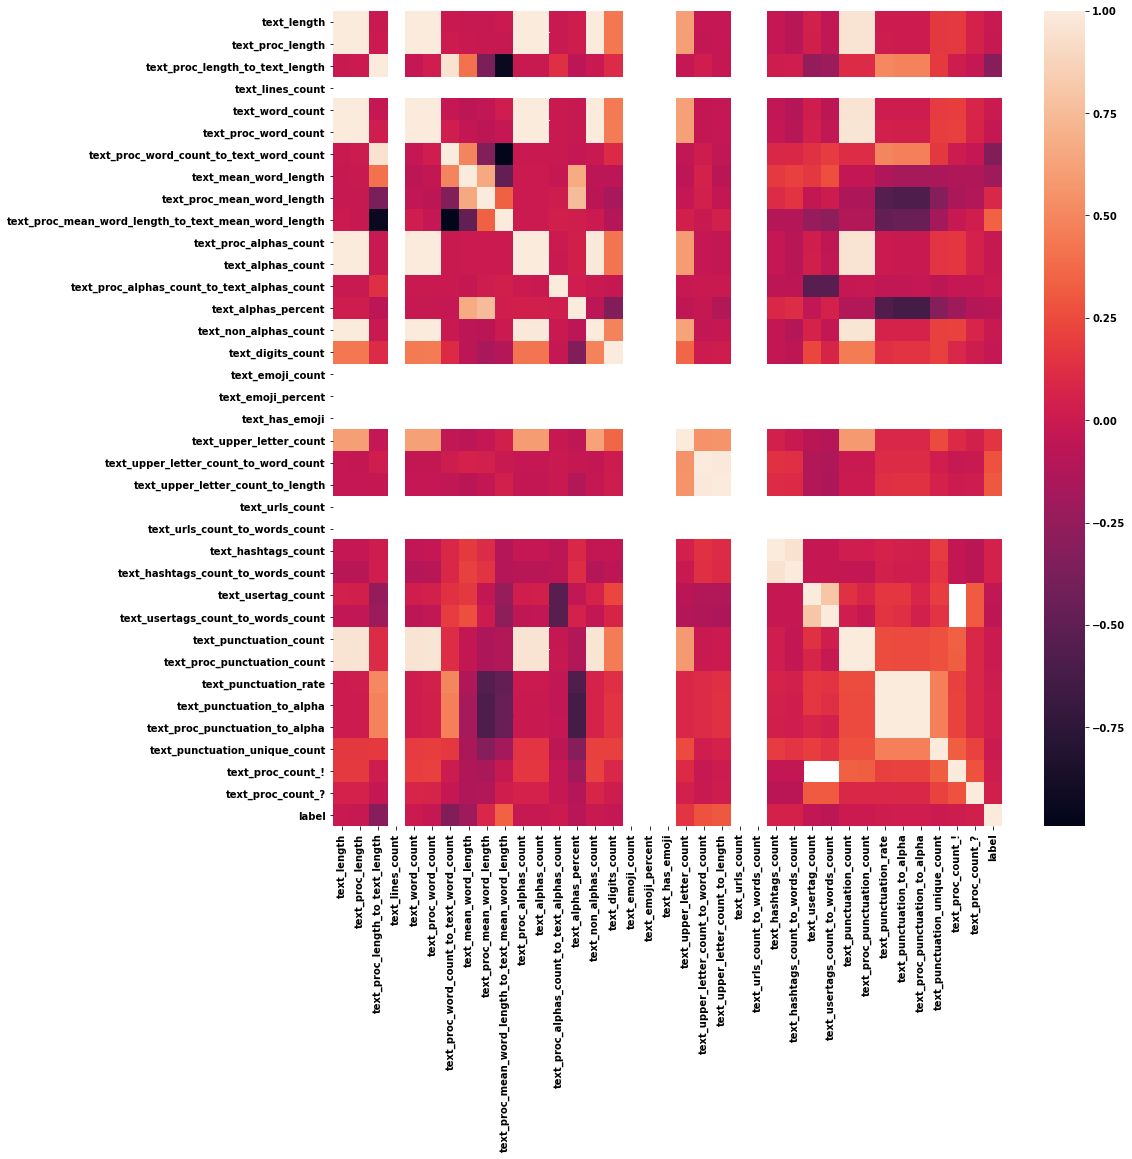

In [142]:
corr = new_df.corr()

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, xticklabels = corr.columns,  yticklabels=corr.columns)

In [143]:
train_labels = new_df["label"]
new_df = new_df.drop("label", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(new_df.replace([np.inf, -np.inf], np.nan), train_labels.astype(int), test_size=0.2, random_state = 42)

In [144]:
numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

In [145]:
clf.fit(X_train, y_train)
print("\t\t Model train score: %.3f" % clf.score(X_train, y_train))
print("\t\t Model test score: %.3f" % clf.score(X_test, y_test))

preds = clf.predict(X_train)
score_test = accuracy_score(y_train, preds)
print("\t\t X_train accuracy score: ", score_test)

preds = clf.predict(X_test)
score_test = accuracy_score(y_test, preds)
print("\t\t Test accuracy score: ", score_test)

		 Model train score: 0.713
		 Model test score: 0.724
		 X_train accuracy score:  0.71296875
		 Test accuracy score:  0.72375


In [146]:
numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', CatBoostRegressor(iterations=3000, learning_rate=0.001, verbose = 0, task_type="GPU", devices='0'))])

In [147]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['text_length', 'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_w...
       'text_hashtags_count_to_words_count', 'text_usertag_count',
       'text_usertags_count_to_words_count', 'text_punctuation_count',
       'text_proc_punctuation_count', 'text_punctuation_rate',
       'text_punctuation_to_alpha', 'text_proc_punctuation_to_alpha',
       'text_punctuation_unique

In [148]:
print("\t\t Model train score: %.3f" % clf.score(X_train, y_train))
print("\t\t Model test score: %.3f" % clf.score(X_test, y_test))

preds = clf.predict(X_train)
preds = [0 if item <= 0.5 else 1 for item in preds]
score_test = accuracy_score(y_train, preds)
print("\t\t X_train accuracy score: ", score_test)

preds = clf.predict(X_test)
preds = [0 if item <= 0.5 else 1 for item in preds]
score_test = accuracy_score(y_test, preds)
print("\t\t Test accuracy score: ", score_test)

		 Model train score: 0.106
		 Model test score: 0.107
		 X_train accuracy score:  0.7084375
		 Test accuracy score:  0.7


In [149]:
ext_test_df_summary = add_text_features(test_df, "summary")
ext_test_df_document = add_text_features(test_df, "document")

new_df = merge_doc_summary_feats(ext_test_df_summary, ext_test_df_document)

In [150]:
new_df.columns

Index(['text_length', 'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_word_length',
       'text_proc_mean_word_length',
       'text_proc_mean_word_length_to_text_mean_word_length',
       'text_proc_alphas_count', 'text_alphas_count',
       'text_proc_alphas_count_to_text_alphas_count', 'text_alphas_percent',
       'text_non_alphas_count', 'text_digits_count', 'text_emoji_count',
       'text_emoji_percent', 'text_has_emoji', 'text_upper_letter_count',
       'text_upper_letter_count_to_word_count',
       'text_upper_letter_count_to_length', 'text_urls_count',
       'text_urls_count_to_words_count', 'text_hashtags_count',
       'text_hashtags_count_to_words_count', 'text_usertag_count',
       'text_usertags_count_to_words_count', 'text_punctuation_count',
       'text_proc_punctuation_count', 'text_punctuation_rate',
       'text_punctuation_

In [151]:
new_df = new_df.replace([np.inf, -np.inf], np.nan)

In [154]:
predictions = clf.predict(new_df)
predictions = [0 if item <= 0.5 else 1 for item in predictions]

In [155]:
# Write predictions to a file
with open("submission_SummaryDocumentFeatGen_CatRegressor.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(predictions):
        csv_out.writerow([i, row])

### Merge Both Features

In [13]:
def merge_doc_summary_feats(ext_train_df_summary, ext_train_df_document, cols= cols):
    ext_train_df_merged = ext_train_df_summary.copy()
    new_df = pd.DataFrame()
    new_cols = []
    for col in cols:
        col_name = col +"_doc"
        ext_train_df_merged[col_name] = ext_train_df_document[col]

        # Use the difference between the original the summary
        name = "ratio_" + col
        ext_train_df_merged[name] = ext_train_df_merged[col] / ext_train_df_merged[col_name]
        new_df[col] = ext_train_df_merged[col] / ext_train_df_merged[col_name]

    return ext_train_df_merged, new_df

ext_train_df_merged, new_df = merge_doc_summary_feats(ext_train_df_summary, ext_train_df_document)
new_df["label"] = ext_train_df_merged["label"]

In [14]:
corr = ext_train_df_merged.corr()
corr["label"].sort_values(ascending=False)

label                                                        1.000000
text_proc_mean_word_length_to_text_mean_word_length          0.358988
ratio_text_proc_mean_word_length_to_text_mean_word_length    0.344849
ratio_text_upper_letter_count_to_length                      0.302707
ratio_text_upper_letter_count_to_word_count                  0.279227
                                                               ...   
ratio_text_emoji_count                                            NaN
ratio_text_emoji_percent                                          NaN
ratio_text_has_emoji                                              NaN
ratio_text_urls_count                                             NaN
ratio_text_urls_count_to_words_count                              NaN
Name: label, Length: 109, dtype: float64

In [15]:
ext_train_df_merged.columns

Index(['document', 'summary', 'label', 'text', 'text_proc', 'text_length',
       'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count',
       ...
       'text_punctuation_to_alpha_doc', 'ratio_text_punctuation_to_alpha',
       'text_proc_punctuation_to_alpha_doc',
       'ratio_text_proc_punctuation_to_alpha',
       'text_punctuation_unique_count_doc',
       'ratio_text_punctuation_unique_count', 'text_proc_count_!_doc',
       'ratio_text_proc_count_!', 'text_proc_count_?_doc',
       'ratio_text_proc_count_?'],
      dtype='object', length=113)

In [165]:
train_labels = ext_train_df_merged["label"]
ext_train_df_merged = ext_train_df_merged.drop(["label", 'document', 'summary', 'text', 'text_proc'] , axis = 1)

X_train, X_test, y_train, y_test = train_test_split(ext_train_df_merged.replace([np.inf, -np.inf], np.nan), train_labels.astype(int), test_size=0.2, random_state = 42)

In [168]:
numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', CatBoostRegressor(iterations=3000, learning_rate=0.01, verbose = 0, task_type="GPU", devices='0'))])

In [169]:
clf.fit(X_train, y_train)

print("\t\t Model train score: %.3f" % clf.score(X_train, y_train))
print("\t\t Model test score: %.3f" % clf.score(X_test, y_test))

preds = clf.predict(X_train)
preds = [0 if item <= 0.5 else 1 for item in preds]
score_test = accuracy_score(y_train, preds)
print("\t\t X_train accuracy score: ", score_test)

preds = clf.predict(X_test)
preds = [0 if item <= 0.5 else 1 for item in preds]
score_test = accuracy_score(y_test, preds)
print("\t\t Test accuracy score: ", score_test)

		 Model train score: 0.376
		 Model test score: 0.348
		 X_train accuracy score:  0.8025
		 Test accuracy score:  0.774375


In [173]:
ext_test_df_summary = add_text_features(test_df, "summary")
ext_test_df_document = add_text_features(test_df, "document")

new_df, _ = merge_doc_summary_feats(ext_test_df_summary, ext_test_df_document)
new_df = new_df.drop(['document', 'summary', 'text', 'text_proc'] , axis = 1)

In [174]:
new_df = new_df.replace([np.inf, -np.inf], np.nan)

predictions = clf.predict(new_df)
predictions = [0 if item <= 0.5 else 1 for item in predictions]

In [175]:
# Write predictions to a file
with open("submission_SummaryDocumentFeatGen_CatRegressor2.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(predictions):
        csv_out.writerow([i, row])